### Store Segmentation
- Features selection
    - internal
    - external
<br><br>
- Feature engineering
    - Feature Scaling
        - normalization
    - Correlation Plot
<br><br>
- Model selection
    - clustering
        - K-Means
        - https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
    - Hierarchical clusting
<br><br>
- Extra
    - compare with existing store format

### Step 1: Features selection
- This step already done in SQL
    - internal
    - external

#### Background: WTCSG

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
import WatsonPyConnect as wpc

db = wpc.PyConnect("CRM_Asia_Tableau")
STORE_SEGMENT_SQL = """select * from STORE_SGMT_MODEL_DATA"""

# Get 3 BU member tier
df = db.to_pandas(STORE_SEGMENT_SQL)

Connected to CRM_Asia_Tableau/ANPRDCAB


### Step 2: Feature engineering
- Understanding the data
- Filling Missing Data
- Separating 
- Feature Scaling

In [18]:
# Understanding the data - examples
df.head(3)

BU_KEY  STORE_KEY       MSP  TOTAL_SALES  MEMBER_SALES  TOTAL_TRXS  \
0      11       4357  0.691670   7620075.26    5270577.10      277920   
1      11       4367  0.703368   1099004.24     773004.49       46475   
2      11       4375  0.471581   2111773.01     995871.99       90557   

   MEMBER_TRXS  MEMBER_COUNT  H_AND_F_SALES_CONT  SKINCARE_SALES_CONT  ...  \
0       153497         56571            0.390943             0.243301  ...   
1        26263         12736            0.400183             0.183865  ...   
2        32785         11743            0.392779             0.156564  ...   

   AGE_GROUP_1_COUNT  AGE_GROUP_2_COUNT  AGE_GROUP_3_COUNT  AGE_GROUP_4_COUNT  \
0               4466              14175              13992              11365   
1                961               3705               3654               2285   
2                358               2526               4116               2420   

   AGE_GROUP_5_COUNT  AGE_GROUP_6_COUNT  ELITE_COUNT  ONLINE_MEMBER_COUNT  \
0              10700               1922         1811                 3180   
1               1683                464          385                  753   
2               1745                592          639                  754   

   AVG_MEM_SALES_DIST  AVG_MEM_TRXS_DIST  
0            0.315219           0.305930  
1            0.219597           0.231003  
2            0.247391           0.272476  

[3 rows x 32 columns]

In [19]:
# Understanding the data - null data / data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 32 columns):
BU_KEY                 164 non-null int64
STORE_KEY              164 non-null int64
MSP                    164 non-null float64
TOTAL_SALES            164 non-null float64
MEMBER_SALES           164 non-null float64
TOTAL_TRXS             164 non-null int64
MEMBER_TRXS            164 non-null int64
MEMBER_COUNT           164 non-null int64
H_AND_F_SALES_CONT     162 non-null float64
SKINCARE_SALES_CONT    162 non-null float64
PC_SALES_CONT          162 non-null float64
COSM_SALES_CONT        161 non-null float64
F_AND_S_SALES_CONT     160 non-null float64
GM_SALES_CONT          160 non-null float64
H_AND_F_MEM_PEN        162 non-null float64
SKINCARE_MEM_PEN       162 non-null float64
PC_MEM_PEN             162 non-null float64
COSM_MEM_PEN           162 non-null float64
F_AND_S_MEM_PEN        162 non-null float64
GM_MEM_PEN             162 non-null float64
REPEAT_MEMBER_COUNT    16

#### Some null datas in some columns

### <font color = 'Orange'>**Filling missing data**</font>

In [20]:
df[pd.isnull(df.AVG_DAYS_COUNT)].iloc[:, :20]

BU_KEY  STORE_KEY  MSP  TOTAL_SALES  MEMBER_SALES  TOTAL_TRXS  \
51       11      12986  0.0      4051.40           0.0          41   
161      11       6846  0.0    578512.77           0.0       25761   

     MEMBER_TRXS  MEMBER_COUNT  H_AND_F_SALES_CONT  SKINCARE_SALES_CONT  \
51             0             0            1.000000                  NaN   
161            0             0            0.378505             0.209903   

     PC_SALES_CONT  COSM_SALES_CONT  F_AND_S_SALES_CONT  GM_SALES_CONT  \
51             NaN              NaN                 NaN            NaN   
161       0.381814         0.002604            0.001114        0.02606   

     H_AND_F_MEM_PEN  SKINCARE_MEM_PEN  PC_MEM_PEN  COSM_MEM_PEN  \
51               NaN               NaN         NaN           NaN   
161              NaN               NaN         NaN           NaN   

     F_AND_S_MEM_PEN  GM_MEM_PEN  
51               NaN         NaN  
161              NaN         NaN

After investigation, null are caused by 2 reasons
- 1. only selling certain types of categories, missing categories are shown as null
- 2. stores only have non-member sales, member sales related KPI, e.g. average member sales contribution is null 

In [21]:
# filling null with zero
df.fillna(0, inplace=True)

In [22]:
# Understanding the data - statistic
df.describe()

BU_KEY     STORE_KEY         MSP   TOTAL_SALES  MEMBER_SALES  \
count   164.0    164.000000  164.000000  1.640000e+02  1.640000e+02   
mean     11.0   5302.890244    0.514918  2.412053e+06  1.454964e+06   
std       0.0   2239.463627    0.177897  3.178351e+06  2.061609e+06   
min      11.0   4356.000000    0.000000  4.051400e+03  0.000000e+00   
25%      11.0   4433.500000    0.386163  2.333372e+05  7.868783e+04   
50%      11.0   4510.500000    0.540784  1.174091e+06  6.295297e+05   
75%      11.0   4593.250000    0.657587  3.284565e+06  1.902469e+06   
max      11.0  14928.000000    0.946596  2.288941e+07  1.356125e+07   

          TOTAL_TRXS    MEMBER_TRXS   MEMBER_COUNT  H_AND_F_SALES_CONT  \
count     164.000000     164.000000     164.000000          164.000000   
mean    96016.335366   44447.475610   18223.591463            0.325106   
std     98660.579428   52606.763382   20795.708620            0.122991   
min        41.000000       0.000000       0.000000            0.000000   
25%     10199.500000    2284.750000    1883.250000            0.276799   
50%     71422.000000   26580.000000    9972.000000            0.331090   
75%    142019.250000   63172.250000   26365.500000            0.380722   
max    455333.000000  228737.000000  101885.000000            1.000000   

       SKINCARE_SALES_CONT  ...  AGE_GROUP_1_COUNT  AGE_GROUP_2_COUNT  \
count           164.000000  ...         164.000000         164.000000   
mean              0.196087  ...        1398.762195        5046.664634   
std               0.079882  ...        1948.065338        6220.503460   
min               0.000000  ...           0.000000           0.000000   
25%               0.156511  ...         104.250000         365.000000   
50%               0.206287  ...         617.500000        2560.000000   
75%               0.250538  ...        1919.250000        7052.750000   
max               0.435105  ...       13375.000000       35034.000000   

       AGE_GROUP_3_COUNT  AGE_GROUP_4_COUNT  AGE_GROUP_5_COUNT  \
count         164.000000         164.000000         164.000000   
mean         4893.518293        3559.810976        2640.926829   
std          5429.280276        3912.359043        2974.228987   
min             0.000000           0.000000           0.000000   
25%           473.500000         505.250000         417.000000   
50%          2679.500000        2238.000000        1731.000000   
75%          7198.250000        5015.750000        3675.000000   
max         25442.000000       18660.000000       14488.000000   

       AGE_GROUP_6_COUNT  ELITE_COUNT  ONLINE_MEMBER_COUNT  \
count         164.000000   164.000000           164.000000   
mean          735.195122   641.518293          1328.932927   
std           922.448535   840.102904          2824.521021   
min             0.000000     0.000000             0.000000   
25%            48.750000    88.000000            96.750000   
50%           432.000000   297.000000           542.000000   
75%          1015.000000   873.250000          1554.250000   
max          4996.000000  5861.000000         31911.000000   

       AVG_MEM_SALES_DIST  AVG_MEM_TRXS_DIST  
count          164.000000         164.000000  
mean             0.237913           0.240786  
std              0.081641           0.091287  
min              0.000000           0.000000  
25%              0.177927           0.163723  
50%              0.225558           0.232078  
75%              0.297477           0.315196  
max              0.431096           0.447364  

[8 rows x 32 columns]

In [23]:
# Understanding the data - columns & size
print(list(df.columns))
print(df.shape)

['BU_KEY', 'STORE_KEY', 'MSP', 'TOTAL_SALES', 'MEMBER_SALES', 'TOTAL_TRXS', 'MEMBER_TRXS', 'MEMBER_COUNT', 'H_AND_F_SALES_CONT', 'SKINCARE_SALES_CONT', 'PC_SALES_CONT', 'COSM_SALES_CONT', 'F_AND_S_SALES_CONT', 'GM_SALES_CONT', 'H_AND_F_MEM_PEN', 'SKINCARE_MEM_PEN', 'PC_MEM_PEN', 'COSM_MEM_PEN', 'F_AND_S_MEM_PEN', 'GM_MEM_PEN', 'REPEAT_MEMBER_COUNT', 'AVG_DAYS_COUNT', 'AGE_GROUP_1_COUNT', 'AGE_GROUP_2_COUNT', 'AGE_GROUP_3_COUNT', 'AGE_GROUP_4_COUNT', 'AGE_GROUP_5_COUNT', 'AGE_GROUP_6_COUNT', 'ELITE_COUNT', 'ONLINE_MEMBER_COUNT', 'AVG_MEM_SALES_DIST', 'AVG_MEM_TRXS_DIST']
(164, 32)


**Separating Categorical variables** <br>
http://www.semspirit.com/artificial-intelligence/machine-learning/preparing-the-data/preparing-the-data-in-python/separating-source-and-target-variables/
https://towardsdatascience.com/data-handling-using-pandas-machine-learning-in-real-life-be76a697418c

- identity variables
- categorical variables <- drop / apply pandas.get_dummies()
- target variables in 

In [24]:
identity_var = ['BU_KEY', 'STORE_KEY']
categorical_var = []
target_var = [] # use in supervisied learning

In [25]:
# raw_data = SEG_data
identity_cols, categorical_cols, source_cols, target_cols = \
    df.loc[:, identity_var], df.loc[:, categorical_var], \
    df.loc[:, df.columns.difference(identity_var+categorical_var+target_var)], \
    df.loc[:, target_var]

-----------------------------------------------
-----------------------------------------------

### Remove Features?
- remove age group by Diagonal Correlation Plot

In [73]:
source_cols.head()

AGE_GROUP_1_COUNT  AGE_GROUP_2_COUNT  AGE_GROUP_3_COUNT  AGE_GROUP_4_COUNT  \
0               4466              14175              13992              11365   
1                961               3705               3654               2285   
2                358               2526               4116               2420   
3                 29                126                165                142   
4                 28                127                168                142   

   AGE_GROUP_5_COUNT  AGE_GROUP_6_COUNT  AVG_DAYS_COUNT  AVG_MEM_SALES_DIST  \
0              10700               1922       71.937483            0.315219   
1               1683                464       66.944642            0.219597   
2               1745                592       60.244094            0.247391   
3                103                 11       30.470085            0.163481   
4                 95                 19       48.258333            0.121264   

   AVG_MEM_TRXS_DIST  COSM_MEM_PEN  ...  MEMBER_TRXS       MSP  \
0           0.305930      0.190964  ...       153497  0.691670   
1           0.231003      0.167242  ...        26263  0.703368   
2           0.272476      0.107724  ...        32785  0.471581   
3           0.144455      0.210069  ...          623  0.375768   
4           0.130218      0.269430  ...          647  0.280505   

   ONLINE_MEMBER_COUNT  PC_MEM_PEN  PC_SALES_CONT  REPEAT_MEMBER_COUNT  \
0                 3180    0.700465       0.270243                27479   
1                  753    0.683260       0.283781                 3765   
2                  754    0.698629       0.346103                 4803   
3                   31    0.243056       0.107469                   39   
4                   37    0.207254       0.047442                   60   

   SKINCARE_MEM_PEN  SKINCARE_SALES_CONT  TOTAL_SALES  TOTAL_TRXS  
0          0.434905             0.243301   7620075.26      277920  
1          0.351366             0.183865   1099004.24       46475  
2          0.337648             0.156564   2111773.01       90557  
3          0.250000             0.222284     54840.21        2486  
4          0.074266             0.055887     53575.71        3615  

[5 rows x 30 columns]

In [61]:
# remove features age group
source_cols_modified = source_cols.iloc[:, 6:]

**Feature Scaling**
- https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [62]:
# encode required
# AGE GROUP 1 to 6 needs to be re-based to percentage

# import regex module
import re

for col in df.columns: 
    if re.match('^AGE_GROUP', col):
        df[col] = df[[col]].apply(lambda x: x/df['MEMBER_COUNT'])

In [63]:
import pandas as pd 
# from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
  
# Initialise the Scaler 
# scaler = StandardScaler()
scaler = MinMaxScaler()
  
# To scale data 
scaled_data = scaler.fit_transform(source_cols_modified) # return ndarray source columns, removed some columns

**Diagonal Correlation Plot**
- https://seaborn.pydata.org/examples/many_pairwise_correlations.html

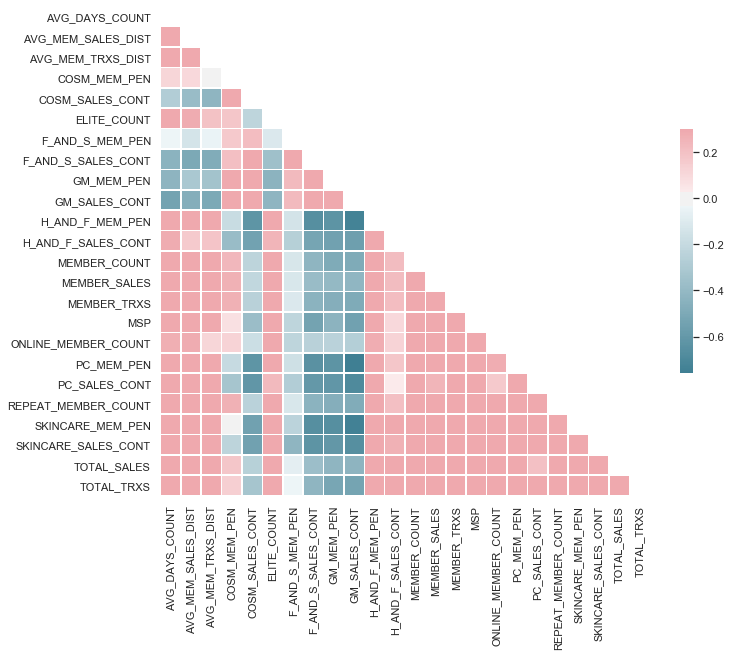

In [65]:
import seaborn as sns
# import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = source_cols_modified.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Scatterplot Matrix**

<Figure size 1440x1440 with 0 Axes>

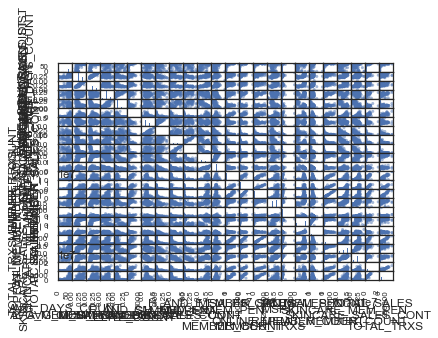

In [66]:
from pandas.plotting import scatter_matrix
plt.figure(figsize=(20,20))
scatter_matrix(source_cols_modified)
plt.show()

----------------
----------------

### Step 3: Model selection
    - clustering
        - K-Means
        https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
    - Hierarchical clusting

#### Get number of clusters

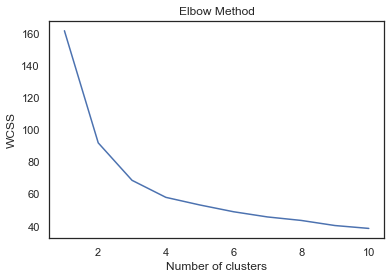

In [67]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

**Number of clusters: 3**

**Apply K-Means**
- https://dotblogs.com.tw/kevinya/2018/06/15/105548

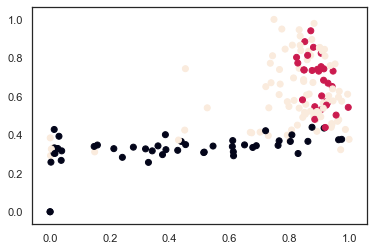

In [68]:
from sklearn.cluster import KMeans

#Clustering in 3 groups
clf = KMeans(n_clusters=3)

# Train the model
clf.fit(scaled_data)

# cluster result
clf.labels_

# Plotting
plt.scatter(scaled_data[:,0],scaled_data[:,2], c=clf.labels_)

**Convert cluster label array into dataframe**

In [69]:
# Convert cluster label array into dataframe
cluster_label = pd.DataFrame(clf.labels_, columns=['Cluster'])

In [70]:
# Merge the label with original data
df_with_label = pd.concat([df, cluster_label], axis=1)

## Silhouette Analysis
- https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a<br><br>
- Silhouette analysis can be used to determine the degree of separation between clusters. For each sample:<br><br>
    - Compute the average distance from all data points in the same cluster (ai).<br><br>
    - Compute the average distance from all data points in the closest cluster (bi).<br><br>
- Compute the coefficient:<br><br>
<img src="https://miro.medium.com/max/274/1*SAdv13fu4zgWRwRvGBrIWQ.png">
<br>
- The coefficient can take values in the interval [-1, 1].<br><br>
    - If it is 0 –> the sample is very close to the neighboring clusters.<br><br>
    - It it is 1 –> the sample is far away from the neighboring clusters.<br><br>
    - It it is -1 –> the sample is assigned to the wrong clusters.

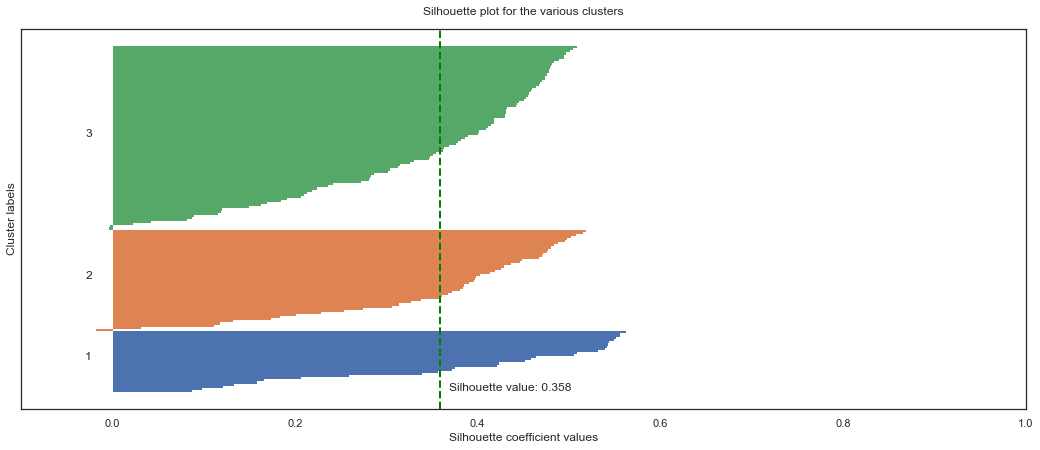

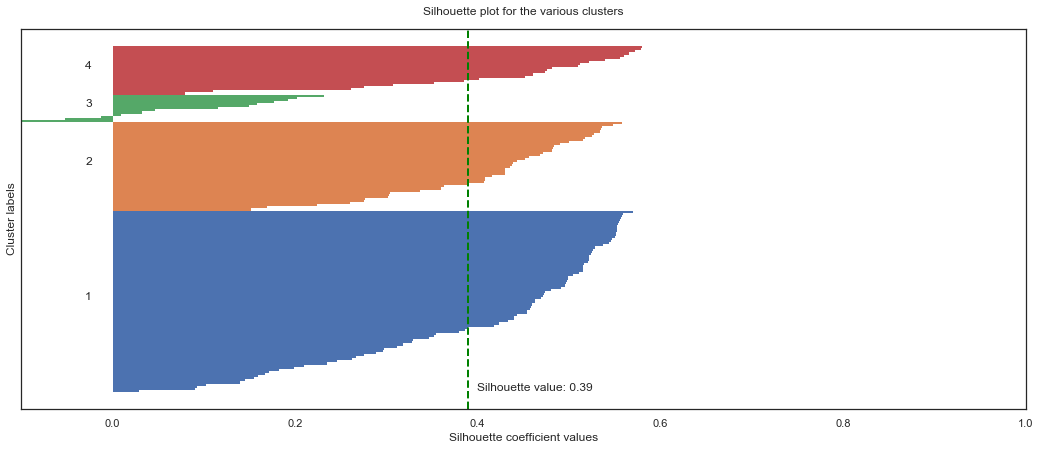

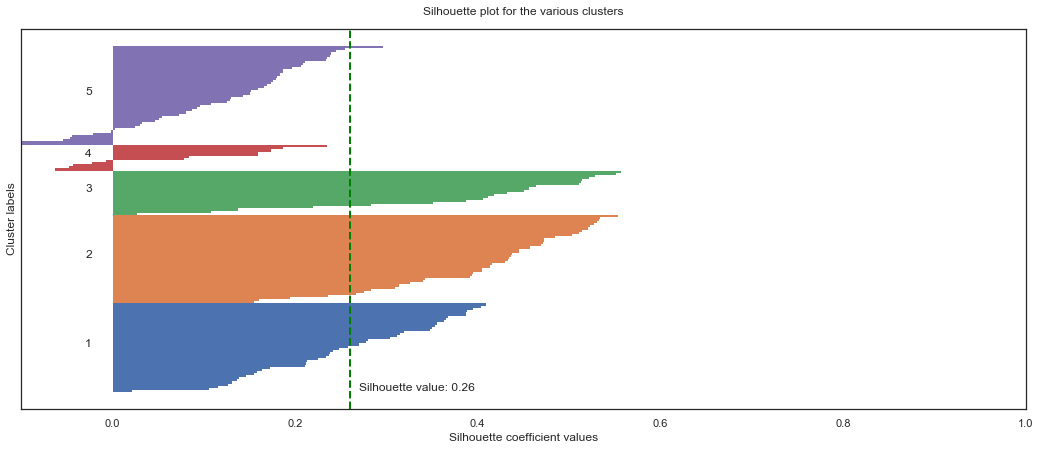

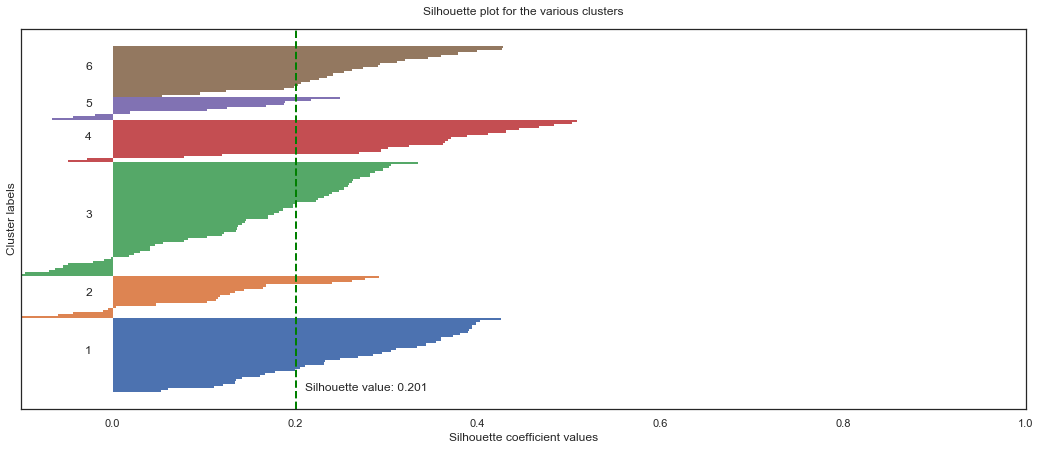

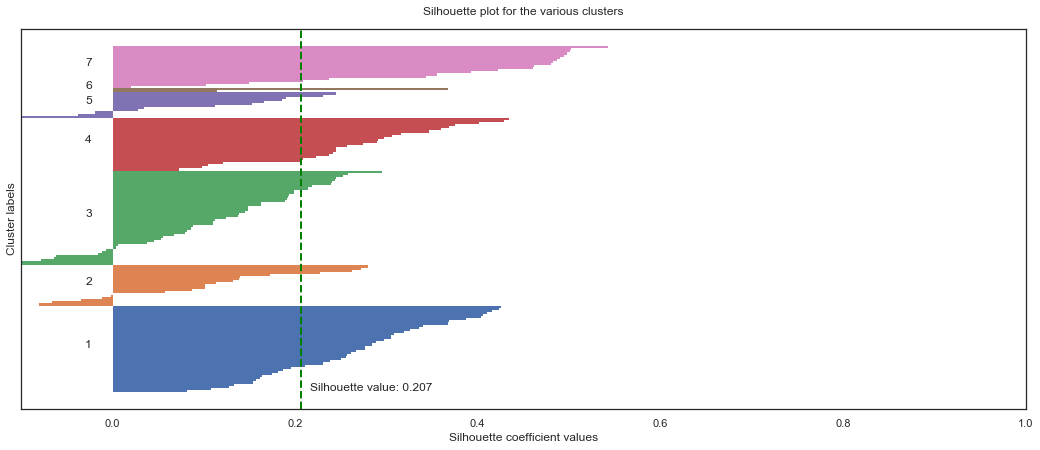

In [71]:
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([3, 4, 5, 6, 7]):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(scaled_data)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(scaled_data, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.text(avg_score + 0.01, 0, 'Silhouette value: ' + str(round(avg_score, 3))) 
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);

### Output Step
- csv format

In [30]:
import os

outname = 'Store Segmentation.csv'

fullname = os.path.join(os.getcwd(), outname)    

df_with_label.to_csv(fullname, sep=',', encoding='utf-8', index=False)